In [24]:
import os
import subprocess
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from imblearn.over_sampling import SMOTE
from sklearn.feature_selection import RFE
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA, KernelPCA
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import train_test_split
from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from imblearn.under_sampling import NearMiss

In [3]:
drought_df = pd.read_csv('../data/drought_v1.csv')
drought_df.head()

,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score
0,1001,2000-01-04,15.95,100.29,6.42,11.40,6.09,6.10,18.09,2.16,...,11.31,3.84,5.67,2.08,3.59,6.73,9.31,3.74,5.58,1
1,1001,2000-01-11,1.33,100.40,6.63,11.48,7.84,7.84,18.88,5.72,...,10.43,1.76,2.48,1.05,1.43,3.55,6.38,1.71,4.67,2
2,1001,2000-01-18,1.11,100.39,9.53,14.28,13.26,13.26,18.04,8.98,...,14.19,2.63,3.60,1.67,1.92,5.19,6.40,3.84,2.55,2
3,1001,2000-01-25,0.00,100.11,2.05,-0.78,-7.93,-7.72,5.65,-5.46,...,-0.61,3.35,4.59,2.28,2.32,5.75,8.03,3.96,4.07,2
4,1001,2000-02-01,0.00,101.00,3.36,2.06,-1.73,-1.70,11.02,-4.21,...,1.88,2.03,2.74,0.88,1.86,4.18,6.38,1.27,5.11,1


In [4]:
drought_df.shape

(1460760, 21)

In [5]:
drought_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460760 entries, 0 to 1460759
Data columns (total 21 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fips         1460760 non-null  int64  
 1   date         1460760 non-null  object 
 2   PRECTOT      1460760 non-null  float64
 3   PS           1460760 non-null  float64
 4   QV2M         1460760 non-null  float64
 5   T2M          1460760 non-null  float64
 6   T2MDEW       1460760 non-null  float64
 7   T2MWET       1460760 non-null  float64
 8   T2M_MAX      1460760 non-null  float64
 9   T2M_MIN      1460760 non-null  float64
 10  T2M_RANGE    1460760 non-null  float64
 11  TS           1460760 non-null  float64
 12  WS10M        1460760 non-null  float64
 13  WS10M_MAX    1460760 non-null  float64
 14  WS10M_MIN    1460760 non-null  float64
 15  WS10M_RANGE  1460760 non-null  float64
 16  WS50M        1460760 non-null  float64
 17  WS50M_MAX    1460760 non-null  float64
 18  WS

##### Check if there is any Missing Values

In [6]:
drought_df.isnull().sum()

fips           0
date           0
PRECTOT        0
PS             0
QV2M           0
T2M            0
T2MDEW         0
T2MWET         0
T2M_MAX        0
T2M_MIN        0
T2M_RANGE      0
TS             0
WS10M          0
WS10M_MAX      0
WS10M_MIN      0
WS10M_RANGE    0
WS50M          0
WS50M_MAX      0
WS50M_MIN      0
WS50M_RANGE    0
score          0
dtype: int64

##### Check if there is any duplicated values

In [7]:
drought_df[drought_df.duplicated()]


,fips,date,PRECTOT,PS,QV2M,T2M,T2MDEW,T2MWET,T2M_MAX,T2M_MIN,...,TS,WS10M,WS10M_MAX,WS10M_MIN,WS10M_RANGE,WS50M,WS50M_MAX,WS50M_MIN,WS50M_RANGE,score


In [8]:
drought_df.duplicated().sum()

np.int64(0)

In [9]:
def date_processing(df, date_column):
    
    df['year'] = pd.DatetimeIndex(df[date_column]).year
    df['month'] = pd.DatetimeIndex(df[date_column]).month
    df['day'] = pd.DatetimeIndex(df[date_column]).day
    df.drop(columns=date_column,inplace=True)
    
    return df

drought_df = date_processing(drought_df, 'date')
drought_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460760 entries, 0 to 1460759
Data columns (total 23 columns):
 #   Column       Non-Null Count    Dtype  
---  ------       --------------    -----  
 0   fips         1460760 non-null  int64  
 1   PRECTOT      1460760 non-null  float64
 2   PS           1460760 non-null  float64
 3   QV2M         1460760 non-null  float64
 4   T2M          1460760 non-null  float64
 5   T2MDEW       1460760 non-null  float64
 6   T2MWET       1460760 non-null  float64
 7   T2M_MAX      1460760 non-null  float64
 8   T2M_MIN      1460760 non-null  float64
 9   T2M_RANGE    1460760 non-null  float64
 10  TS           1460760 non-null  float64
 11  WS10M        1460760 non-null  float64
 12  WS10M_MAX    1460760 non-null  float64
 13  WS10M_MIN    1460760 non-null  float64
 14  WS10M_RANGE  1460760 non-null  float64
 15  WS50M        1460760 non-null  float64
 16  WS50M_MAX    1460760 non-null  float64
 17  WS50M_MIN    1460760 non-null  float64
 18  WS

In [10]:
import pandas as pd

def remove_outliers(df, columns, threshold=3):
    for column in columns:
        mean = df[column].mean()
        std_dev = df[column].std()
        df = df[(df[column] <= mean + threshold * std_dev) & 
                (df[column] >= mean - threshold * std_dev)]
    
    return df

# List of columns to filter
columns_to_filter = [
    'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX', 'T2M_MIN', 
    'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN', 'WS10M_RANGE', 
    'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE'
]

drought_df = remove_outliers(drought_df, columns_to_filter)
print('Total rows = ', len(drought_df.index))

Total rows =  1315824


##### Splitting into train and test

In [11]:
target = drought_df['score']
target.head()

0    1
1    2
2    2
3    2
4    1
Name: score, dtype: int64

In [12]:
independent_variables = drought_df.drop('score', axis=1)
independent_variables.columns

Index(['fips', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_MIN',
       'WS10M_RANGE', 'WS50M', 'WS50M_MAX', 'WS50M_MIN', 'WS50M_RANGE', 'year',
       'month', 'day'],
      dtype='object')

In [13]:
X_train, X_test, y_train, y_test = train_test_split(independent_variables, target, test_size=0.2, random_state=42, stratify=target)
print("X_train shape: ",X_train.shape)
print("y_train shape: ",y_train.shape)
print("X_test shape: ",X_test.shape)
print("y_test shape: ",y_test.shape)

X_train shape:  (1052659, 22)
y_train shape:  (1052659,)
X_test shape:  (263165, 22)
y_test shape:  (263165,)


##### Feature Selection

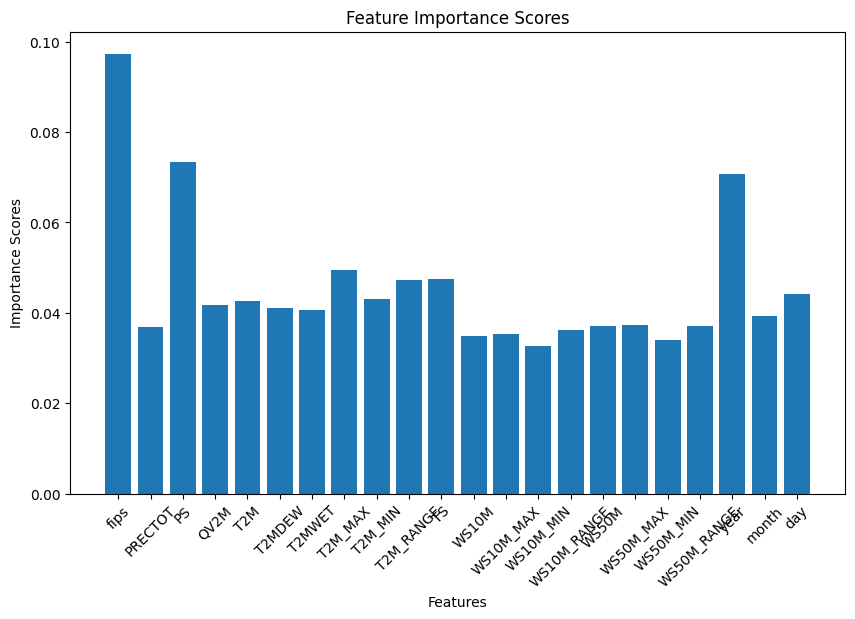

In [14]:
classifier = RandomForestClassifier(n_estimators=10) # n is 100 by default we reduced it
classifier.fit(X_train, y_train)

feature_importance = classifier.feature_importances_

plt.figure(figsize=(10, 6))
plt.bar(independent_variables.columns, feature_importance)
# plt.bar(X_train.columns, feature_importance)

plt.xlabel('Features')
plt.ylabel('Importance Scores')
plt.title('Feature Importance Scores')
plt.xticks(rotation=45)
plt.show()

In [15]:
# Feature selection using RFE (Recursive Feature Elimination) with RandomForest

model = RandomForestClassifier(n_estimators=10) # n_estimators is the hyperparameter
rfe = RFE(model, n_features_to_select=15) 
fit = rfe.fit(X_train, y_train)
print("Num Features: %s" % (fit.n_features_))
print("Selected Features: %s" % (fit.support_))
print("Feature Ranking: %s" % (fit.ranking_))
selected_features = independent_variables.columns[(fit.get_support())]
print(selected_features)

Num Features: 15
Selected Features: [ True False  True  True  True  True False  True  True  True  True  True
 False False  True  True False False  True  True False  True]
Feature Ranking: [1 5 1 1 1 1 3 1 1 1 1 1 6 8 1 1 2 7 1 1 4 1]
Index(['fips', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2M_MAX', 'T2M_MIN',
       'T2M_RANGE', 'TS', 'WS10M', 'WS10M_RANGE', 'WS50M', 'WS50M_RANGE',
       'year', 'day'],
      dtype='object')


In [16]:
selector = VarianceThreshold(threshold=3.5)  # Adjust threshold as needed
X_train_var = selector.fit_transform(X_train)
X_test_var = selector.transform(X_test)

# Get the remaining features after applying variance threshold
remaining_features = X_train.columns[selector.get_support()]
print(f"Features after variance thresholding: {remaining_features}")

Features after variance thresholding: Index(['fips', 'PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M_MAX', 'WS50M', 'WS50M_MAX',
       'WS50M_MIN', 'year', 'month', 'day'],
      dtype='object')


In [17]:
selector = SelectKBest(score_func=f_classif, k=15)  # Select the top 15 features
X_train_kbest = selector.fit_transform(X_train, y_train)
X_test_kbest = selector.transform(X_test)

# Step 3: Get the selected features
selected_features = X_train.columns[selector.get_support()]
print(f"Selected Features: {selected_features}")

Selected Features: Index(['PRECTOT', 'PS', 'QV2M', 'T2M', 'T2MDEW', 'T2MWET', 'T2M_MAX',
       'T2M_MIN', 'T2M_RANGE', 'TS', 'WS10M', 'WS10M_MAX', 'WS10M_RANGE',
       'WS50M_RANGE', 'year'],
      dtype='object')


##### PCA for dimensionality reduction

In [18]:
pca = PCA()
X_train_PCAreduced = pca.fit_transform(X_train)
X_test_PCAreduced = pca.transform(X_test)

In [19]:
print(pca.explained_variance_ratio_)

[9.99996208e-01 2.87226877e-06 3.47764866e-07 2.11884402e-07
 9.38277880e-08 7.38336552e-08 5.11975298e-08 4.24459542e-08
 3.34092381e-08 2.91971083e-08 2.23492716e-08 5.33027432e-09
 3.20930581e-09 2.83468169e-09 9.03827123e-10 7.11793609e-10
 5.55450435e-10 1.39781565e-10 6.02843517e-12 3.75329777e-14
 3.73632337e-14 3.71719189e-14]


In [20]:
# choosing n value that explains >90% variance
pca = PCA(n_components=10)
X_train_PCAreduced = pca.fit_transform(X_train)
X_test_ = pca.transform(X_test)
print(pca.explained_variance_ratio_)

[9.99996208e-01 2.87226877e-06 3.47764866e-07 2.11884402e-07
 9.38277880e-08 7.38336552e-08 5.11975298e-08 4.24459542e-08
 3.34092381e-08 2.91971083e-08]


##### Standardizing the data


In [25]:
sc = StandardScaler()
X_train = sc.fit_transform(X_train)
X_test = sc.transform(X_test)

##### Fixing class imbalance


In [26]:
# Upsampling using SMOTE
sm = SMOTE(random_state = 5)
X_train_ups, y_train_ups = sm.fit_resample(X_train, y_train.ravel())

/tmp/ipykernel_392483/3966991691.py:3: FutureWarning: Series.ravel is deprecated. The underlying array is already 1D, so ravel is not necessary.  Use `to_numpy()` for conversion to a numpy array instead.
  X_train_ups, y_train_ups = sm.fit_resample(X_train, y_train.ravel())


In [28]:
def print_summary(X_train, X_train_smote, y_train, y_train_smote):
    
   
    print('Before OverSampling, the shape of train_X: {}'.format(X_train.shape))
    print('Before OverSampling, the shape of train_y: {} \n'.format(y_train.shape))

    print('After OverSampling, the shape of train_X: {}'.format(X_train_smote.shape))
    print('After OverSampling, the shape of train_y: {} \n'.format(y_train_smote.shape))
    
    # Extract unique classes from the target
    unique_classes = sorted(set(y_train))
    
    # Print the counts for each class before and after oversampling
    for label in unique_classes:
        print(f"Counts of label '{label}' - Before Oversampling: {sum(y_train == label)}, After OverSampling: {sum(y_train_smote == label)}")


In [30]:
print_summary(X_train,X_train_ups,y_train,y_train_ups)

Before OverSampling, the shape of train_X: (1052659, 22)
Before OverSampling, the shape of train_y: (1052659,) 

After OverSampling, the shape of train_X: (3686064, 22)
After OverSampling, the shape of train_y: (3686064,) 

Counts of label '0' - Before Oversampling: 614344, After OverSampling: 614344
Counts of label '1' - Before Oversampling: 180554, After OverSampling: 614344
Counts of label '2' - Before Oversampling: 123322, After OverSampling: 614344
Counts of label '3' - Before Oversampling: 84854, After OverSampling: 614344
Counts of label '4' - Before Oversampling: 39718, After OverSampling: 614344
Counts of label '5' - Before Oversampling: 9867, After OverSampling: 614344


##### Downsampling using Near Miss

In [31]:
undersample = NearMiss()
X_train_dres, y_train_dres = undersample.fit_resample(X_train, y_train)

In [32]:
print_summary(X_train,X_train_dres,y_train,y_train_dres)

Before OverSampling, the shape of train_X: (1052659, 22)
Before OverSampling, the shape of train_y: (1052659,) 

After OverSampling, the shape of train_X: (59202, 22)
After OverSampling, the shape of train_y: (59202,) 

Counts of label '0' - Before Oversampling: 614344, After OverSampling: 9867
Counts of label '1' - Before Oversampling: 180554, After OverSampling: 9867
Counts of label '2' - Before Oversampling: 123322, After OverSampling: 9867
Counts of label '3' - Before Oversampling: 84854, After OverSampling: 9867
Counts of label '4' - Before Oversampling: 39718, After OverSampling: 9867
Counts of label '5' - Before Oversampling: 9867, After OverSampling: 9867


In [41]:
train_path = "../data/train/"

os.makedirs(train_path, exist_ok=True)

# Save datasets
pd.DataFrame(X_train).to_csv(os.path.join(train_path, "X_train.csv"), index=False)
pd.DataFrame(y_train).to_csv(os.path.join(train_path, "y_train.csv"), index=False)
pd.DataFrame(X_train_ups).to_csv(os.path.join(train_path, "X_train_ups.csv"), index=False)
pd.DataFrame(y_train_ups).to_csv(os.path.join(train_path, "y_train_ups.csv"), index=False)
pd.DataFrame(X_train_dres).to_csv(os.path.join(train_path, "X_train_dres.csv"), index=False)
pd.DataFrame(y_train_dres).to_csv(os.path.join(train_path, "y_train_dres.csv"), index=False)
pd.DataFrame(X_test).to_csv(os.path.join(train_path, "X_test.csv"), index=False)
pd.DataFrame(y_test).to_csv(os.path.join(train_path, "y_test.csv"), index=False)
